In [100]:
from kuramoto.SDL_SVP import SDL_SVP
from kuramoto.SDL_BCD import SDL_BCD
from kuramoto.SNMF import SNMF
from kuramoto.LMF import LMF
from kuramoto.nmf import *

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression

In [6]:
sampling_alg = 'pivot'

ntwk = 'UCLA26' # COVID_PPI, Wisconsin87, Caltech36, UCLA26
ntwk_nonumber = ''.join([i for i in ntwk if not i.isdigit()])
save_folder = 'images/'
k = 50

path = "../Data/Networks_all_NDL/" + str(ntwk) + '.txt'
G = nn.NNetwork()
G.load_add_edges(path, increment_weights=False, use_genfromtxt=True)
print('num nodes in G', len(G.nodes()))
print('num edges in G', len(G.get_edges()))

num nodes in G 20467
num edges in G 1495226


num of subgraphs induced on k-paths: 900
X.shape (2500, 900)


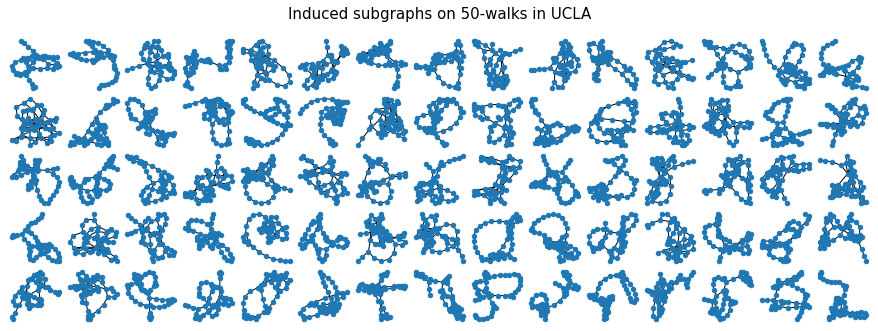

In [7]:
X, embs = G.get_patches(k=k, sample_size=900, skip_folded_hom=True)

display_graphs(title='Induced subgraphs on {}-walks in {}'.format(k, ntwk_nonumber),
                 save_path=save_folder + ntwk_nonumber + "_subgraphs_"+ str(sampling_alg) + "_walk", 
                 data = [X, embs],
                 grid_shape = [5, 15],
                 fig_size = [15, 5],
                 show_importance=False)

In [8]:
graph_list = generate_nxg(X)
print(f"num of graphs: {len(graph_list)}")

num of graphs: 900


In [16]:
nodes = int(np.sqrt(X.shape[0]))
df = pd.DataFrame()
K = 5

for G in graph_list:
        
    if nx.is_connected(G):

        adj_mat = nx.to_numpy_array(G)
        temp = pd.DataFrame(np.array(nx.adjacency_matrix(G).todense().flatten('C')))
        
        model = Kuramoto(coupling=K, dt=0.01, T=18, n_nodes=nodes, half_sync=False)

        sim = model.run(adj_mat)
        arr = sim.T[-1]
        conc = pd.DataFrame(pd.Series(synchronization(arr)), columns=['Synchronized'])
            
        temp = pd.concat([temp, conc], axis=1)

        df = pd.concat([df, temp], ignore_index=True)
    
df

,0,1,2,3,4,5,6,7,8,9,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,Synchronized
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,False
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,True
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False
896,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False
897,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False
898,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,False


In [17]:
print(f"% of synchronized cases: {sum(df['Synchronized'])/len(df)}")

% of synchronized cases: 0.23333333333333334


In [43]:
X = df.drop(['Synchronized'], axis=1).values
Y = df['Synchronized'].values.reshape(-1,1)

In [44]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, 
                                                    test_size=0.33)

## SNMF

In [160]:
iteration1 = 200 # Iteration for logistic training
xi_list = [0, 0.1, 1, 5, 10] # Trade-off parameters
beta = 1
iter_avg = 4
r = 16

SNMF_AUC_array = np.zeros(shape=[iter_avg, len(xi_list)]) 

for j in range(len(xi_list)):
    xi = xi_list[j]
    for i in range(iter_avg):
        SNMF_class_new = SNMF(X=[X_train.T, Y_train.T],
                              X_test=[X_test.T, Y_test.T],
                              n_components=r,
                              xi=xi,
                              L1_reg = [0,0,0],
                              L2_reg = [0,0,0],
                              nonnegativity=[True,True,False],
                              full_dim=False)

        results_dict_new_snmf_cv = SNMF_class_new.train_logistic(iter=iteration1, 
                                                                 subsample_size=None, 
                                                                 beta = beta,
                                                                 search_radius_const=1,
                                                                 update_nuance_param=False,
                                                                 if_compute_recons_error=False, 
                                                                 if_validate=False)

        SNMF_AUC_array[i, j] = results_dict_new_snmf_cv.get('Accuracy')

xi_SNMF = xi_list[np.argmax(np.sum(SNMF_AUC_array, 0))]

initial loading beta [[-0.30204416  0.13996348  0.40269625 -0.85569536 -0.94207827  0.11317069
   0.23852937 -0.59684181  0.8087538  -0.13301823 -0.06764521 -0.67317391
   0.37375737 -0.82883762  0.38375664 -0.98178006 -0.61262429]]


100%|█████████████████████████████████████████| 200/200 [00:19<00:00, 10.31it/s]


initial loading beta [[-0.87326257 -0.04002989 -0.96658151 -0.23640676 -0.44675025 -0.64858272
  -0.86114329 -0.0932165   0.08892666 -0.43833178 -0.9346906  -0.9114782
  -0.21278464  0.37549778 -0.86039131 -0.55916993 -0.09259018]]


100%|█████████████████████████████████████████| 200/200 [00:20<00:00,  9.81it/s]


initial loading beta [[-0.7569881   0.05793187 -0.36293414  0.19422239  0.75415164 -0.81047863
   0.32436137  0.34827004 -0.02180538  0.72550123  0.9082995   0.94242845
  -0.46712328  0.54350072  0.13715315 -0.40946538  0.94619555]]


100%|█████████████████████████████████████████| 200/200 [00:17<00:00, 11.55it/s]


initial loading beta [[ 0.62954844 -0.93687167 -0.81903843  0.84304965  0.3532368   0.5813101
  -0.27468275  0.48378836 -0.83674779  0.55109076  0.55995732 -0.07501987
   0.88636786  0.22222074  0.15963679  0.78998924  0.30116075]]


100%|█████████████████████████████████████████| 200/200 [00:20<00:00,  9.53it/s]


initial loading beta [[-0.00450631 -0.7038958   0.73498507 -0.99245787 -0.59366715  0.72311598
   0.87030026 -0.43108245  0.78250969 -0.83360622 -0.30814664  0.25271285
   0.90460676 -0.94063949 -0.66886502  0.74969201 -0.63025619]]


100%|█████████████████████████████████████████| 200/200 [00:20<00:00,  9.79it/s]


initial loading beta [[-0.26892793 -0.48887759  0.00729138 -0.19133723 -0.3355797  -0.75858592
   0.97012771 -0.43083636  0.65202287 -0.23419704 -0.6530236  -0.60703222
   0.03075492 -0.47479348  0.11395308 -0.11699269 -0.28450123]]


100%|█████████████████████████████████████████| 200/200 [00:21<00:00,  9.52it/s]


initial loading beta [[-0.19152215 -0.91444592  0.56675239 -0.44815655  0.48650502 -0.96897936
  -0.57080489  0.26822219  0.27051779  0.42151582  0.89305727 -0.8351058
  -0.54295514 -0.54388338 -0.57647519  0.35712693  0.11508685]]


100%|█████████████████████████████████████████| 200/200 [00:20<00:00,  9.62it/s]


initial loading beta [[-0.3203114   0.10050359  0.50767189 -0.2128203  -0.61263702 -0.642416
   0.74059727 -0.9578394  -0.5801759  -0.42907011 -0.05890279 -0.74649443
  -0.70640559 -0.71582596 -0.52478137 -0.8721621   0.3730133 ]]


100%|█████████████████████████████████████████| 200/200 [00:25<00:00,  7.75it/s]


initial loading beta [[-0.51228297  0.51736944 -0.80933369  0.58463943 -0.73874704  0.69371802
   0.45190653  0.64560422 -0.40830195 -0.65483846  0.69700544  0.04921882
   0.12335534  0.88095537  0.53666075 -0.33769295 -0.95401834]]


100%|█████████████████████████████████████████| 200/200 [00:16<00:00, 12.08it/s]


initial loading beta [[-0.98481685 -0.03221776  0.82303276 -0.51502007 -0.80840872 -0.7390945
  -0.35770162 -0.88262109  0.54919314  0.2446486   0.88690348 -0.4463169
   0.00936831 -0.02571734 -0.98070971  0.3479142   0.64543969]]


100%|█████████████████████████████████████████| 200/200 [00:17<00:00, 11.66it/s]


initial loading beta [[-0.30670264 -0.9483065  -0.04764615 -0.71777611 -0.25997284 -0.45669376
  -0.83328841  0.33255165 -0.66060223 -0.1019479  -0.77183769 -0.5977625
   0.10870489  0.76971392 -0.31691276 -0.75038239 -0.1555258 ]]


100%|█████████████████████████████████████████| 200/200 [00:16<00:00, 12.22it/s]


initial loading beta [[ 0.97311276  0.31170319  0.709695    0.15618541  0.16185892  0.10581679
   0.41837154  0.59377009  0.83813088  0.13860424 -0.18844671 -0.83364354
  -0.61003072  0.61727009  0.13205875 -0.52742764  0.16119308]]


100%|█████████████████████████████████████████| 200/200 [00:16<00:00, 12.25it/s]


initial loading beta [[-0.18234931 -0.4850799  -0.09143066  0.70559535 -0.59553331 -0.2164767
   0.53172261  0.02006115  0.03539807 -0.43597575 -0.61000175  0.00541815
  -0.22084263  0.12705173 -0.06498065  0.11693118  0.07687581]]


100%|█████████████████████████████████████████| 200/200 [00:20<00:00,  9.96it/s]


initial loading beta [[ 0.01618578  0.92483768 -0.59761839  0.13078483  0.16312081 -0.90616557
  -0.63148388  0.38109394 -0.24724547  0.3113867   0.19333667  0.41240066
   0.23442285  0.75958534  0.72218763 -0.69319159  0.8772547 ]]


100%|█████████████████████████████████████████| 200/200 [00:20<00:00,  9.99it/s]


initial loading beta [[ 0.47933264  0.34584369  0.49837499  0.25756612  0.45555263 -0.86400089
  -0.67116761  0.40292578 -0.80244692  0.03836347 -0.71139739 -0.01175816
   0.57975313 -0.04429903 -0.62894995  0.55105011  0.34866955]]


100%|█████████████████████████████████████████| 200/200 [00:19<00:00, 10.50it/s]


initial loading beta [[ 0.25106726 -0.73124495  0.8417527   0.90265187  0.95962821 -0.28351722
   0.44963725  0.43570969 -0.48739063  0.27597496 -0.43181505  0.37565993
   0.34558268  0.72670014  0.79980562  0.4401713  -0.92454652]]


100%|█████████████████████████████████████████| 200/200 [00:20<00:00,  9.56it/s]


initial loading beta [[ 0.96801814 -0.77727033 -0.43905565 -0.85480268 -0.63474337 -0.52062607
   0.58124975 -0.36555961 -0.31281179 -0.99879608  0.36576298 -0.41559618
  -0.25463049 -0.31716068 -0.59349085 -0.47308661  0.11231946]]


100%|█████████████████████████████████████████| 200/200 [00:20<00:00,  9.64it/s]


initial loading beta [[-0.52750575 -0.90965127 -0.29492903  0.32867636  0.00716417 -0.27833204
   0.84085379  0.12876879  0.58152929 -0.86483593  0.20528018 -0.80389735
  -0.82700933 -0.57295082 -0.46517527  0.15154291  0.33285616]]


100%|█████████████████████████████████████████| 200/200 [00:19<00:00, 10.26it/s]


initial loading beta [[ 0.14145357 -0.67942685  0.58601112  0.86673576  0.58723258 -0.44928915
  -0.08720033 -0.5877872  -0.13957195  0.62314063  0.94613786 -0.3242238
  -0.22917626 -0.14095871 -0.30542784  0.64503135 -0.17549327]]


100%|█████████████████████████████████████████| 200/200 [00:19<00:00, 10.24it/s]


initial loading beta [[-0.4143722   0.18458128 -0.71460703  0.01959948  0.27841126 -0.92276164
  -0.43862612  0.61701     0.74335088  0.87132415  0.69148964  0.89053546
   0.0254591  -0.89340622  0.59241828  0.7071056   0.77639012]]


100%|█████████████████████████████████████████| 200/200 [00:19<00:00, 10.13it/s]


In [71]:
results_dict_new_snmf_cv

{'xi': 10,
 'L1_reg': [0, 0, 0],
 'L2_reg': [0, 0, 0],
 'nonnegativity': [True, True, False],
 'n_components': 32,
 'loading': [array([[0.00000000e+00, 0.00000000e+00, 3.59428946e-07, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [1.81203004e-02, 1.72255654e-02, 1.70309744e-02, ...,
          1.76719638e-02, 1.70436923e-02, 1.77151253e-02],
         [2.15168131e-03, 2.00516440e-03, 2.02946066e-03, ...,
          1.88155733e-03, 2.12123106e-03, 2.03104282e-03],
         ...,
         [2.94503258e-03, 2.94761371e-03, 2.75793611e-03, ...,
          2.50928442e-03, 2.82059497e-03, 2.65981158e-03],
         [1.81219094e-02, 1.72242178e-02, 1.70301073e-02, ...,
          1.76712912e-02, 1.70440173e-02, 1.77151892e-02],
         [9.23630686e-08, 2.36260177e-07, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00]]),
  array([[-8.02728183,  0.09785911,  0.1217433 ,  0.1076521 ,  0.10982251,
           0.11234054,  0.07674017,  0.19777283,  0

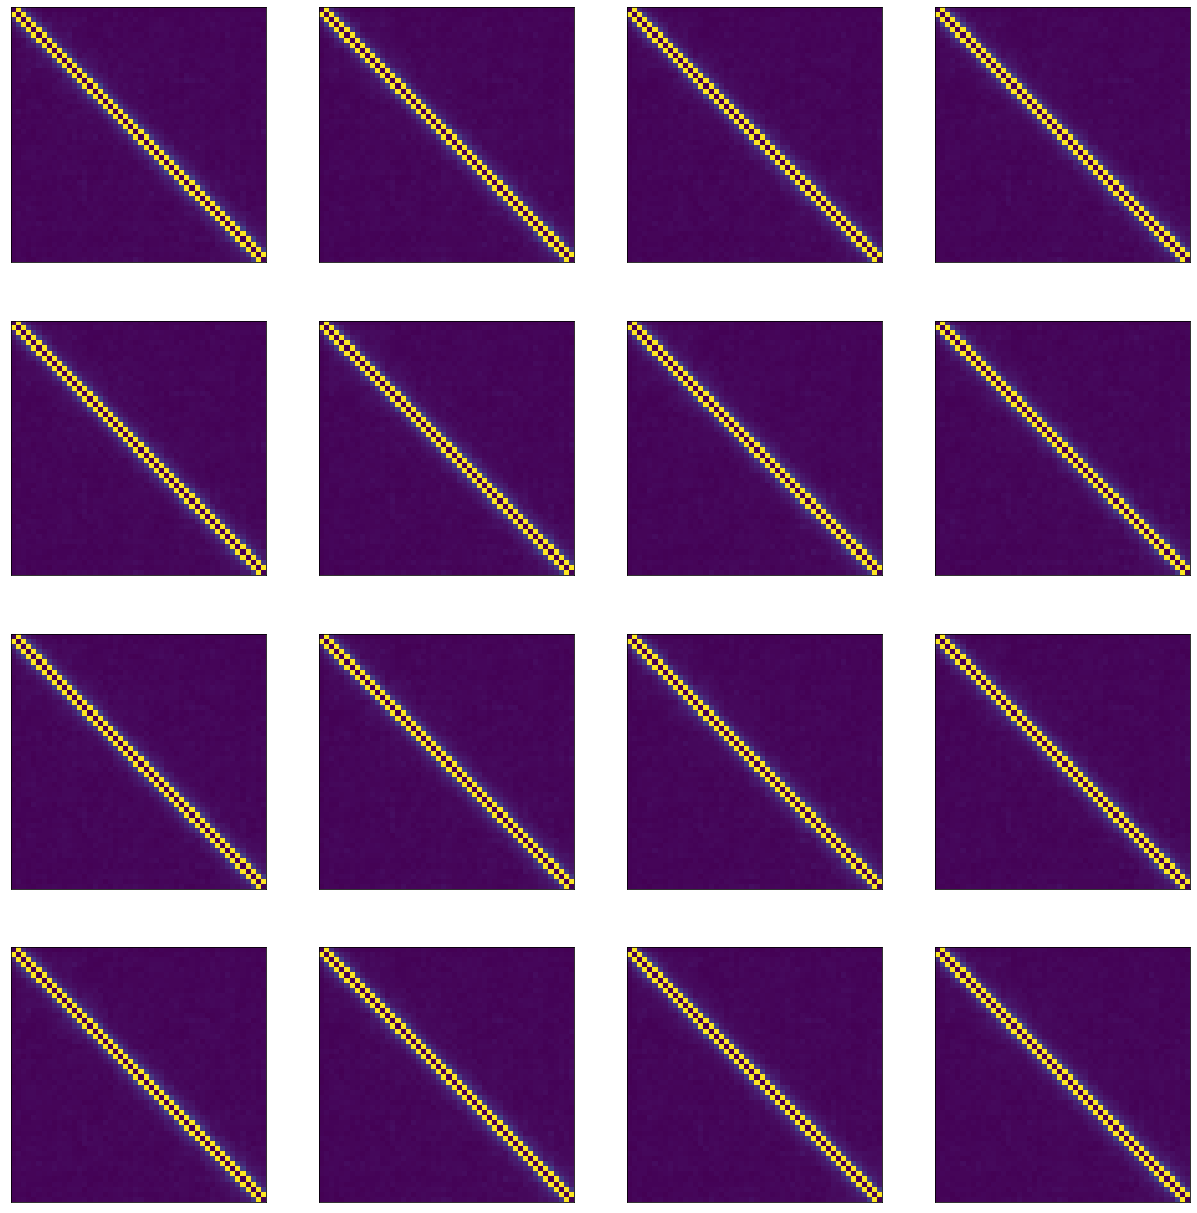

In [163]:
W = results_dict_new_snmf_cv.get('loading')[0]
display_dictionary(save_name=save_folder+'UCLA_SNMF_Dictionaries', W=W, figsize=[20,20])

## LMF

In [156]:
iteration = 200
results_dict_list = []
xi_list = [0, 0.1, 1, 10]
beta_list = [1, None]
iter_avg = 4
r = 16

LMF_AUC_array_naive = np.zeros(shape=[iter_avg, len(xi_list)])
LMF_AUC_array_exhaustive = np.zeros(shape=[iter_avg, len(xi_list)])

for beta in beta_list:
    for j in range(len(xi_list)):
        xi = xi_list[j]
        for i in range(iter_avg):
            LMF_class_new = LMF(X = [X_train.T, Y_train.T],
                            X_test = [X_test.T, Y_test.T],
                            n_components = r,
                            xi = xi,
                            L1_reg = [0,0,0],
                            L2_reg = [0,0,1],
                            nonnegativity=[True,True,False],
                            full_dim=False)

            results_dict_new = LMF_class_new.train_logistic(iter=iteration, subsample_size=None, 
                                                    beta = beta, 
                                                    search_radius_const=1000,
                                                    fine_tune_beta=True,
                                                    update_nuance_param=False,
                                                    if_compute_recons_error=False, if_validate=False)

            results_dict_new.update({'method': 'SDL-feat (naive)'})
            results_dict_new.update({'beta': beta})
            results_dict_new.update({'Accuracy': results_dict_new.get('Accuracy (naive)')})
            results_dict_new.update({'F_score': results_dict_new.get('F_score (naive)')})
            results_dict_list.append(results_dict_new.copy())

            results_dict_new1 = results_dict_new.copy()
            results_dict_new1.update({'method': 'SDL-feat (exhaustive)'})
            results_dict_new1.update({'beta': beta})
            results_dict_new1.update({'Accuracy': results_dict_new1.get('Accuracy (exhaustive)')})
            results_dict_new1.update({'F_score': results_dict_new.get('F_score (exhaustive)')})
            results_dict_list.append(results_dict_new1.copy())

            LMF_AUC_array_naive[i,j] = results_dict_new.get('Accuracy (naive)') 
            LMF_AUC_array_exhaustive[i,j] = results_dict_new.get('Accuracy (exhaustive)')

initial loading beta [[0.55303175 0.58986303 0.79568052 0.94424693 0.62546548 0.99815935
  0.31615425 0.44411223 0.82104641 0.1289683  0.43170447 0.3273923
  0.9723251  0.05494816 0.30101995 0.51674193 0.08618396]]


100%|█████████████████████████████████████████| 200/200 [00:05<00:00, 35.02it/s]


!!! pred_type naive
--- Validation --- [threshold, AUC, Accuracy, F score] =  [1.0, 0.526, 0.663, 0.275]
!!! pred_type exhaustive
exhaustive prection..


100%|█████████████████████████████████████████| 297/297 [00:10<00:00, 29.37it/s]


--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.0, 0.533, 0.724, 0.255]
initial loading beta [[0.08383956 0.58082781 0.98830308 0.40693756 0.83461931 0.70424178
  0.80720129 0.22003502 0.47609133 0.58935244 0.70000391 0.68178921
  0.82116938 0.56376046 0.86768752 0.40532929 0.8023327 ]]


100%|█████████████████████████████████████████| 200/200 [00:05<00:00, 35.20it/s]


!!! pred_type naive
--- Validation --- [threshold, AUC, Accuracy, F score] =  [1.0, 0.535, 0.66, 0.34]
!!! pred_type exhaustive
exhaustive prection..


100%|█████████████████████████████████████████| 297/297 [00:10<00:00, 29.20it/s]


--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.0, 0.491, 0.714, 0.141]
initial loading beta [[0.3523471  0.84249668 0.62634023 0.38009882 0.17686237 0.79334827
  0.27322729 0.59577468 0.22165074 0.11694194 0.3816339  0.22346352
  0.31218324 0.65720594 0.29957669 0.02825464 0.96407148]]


100%|█████████████████████████████████████████| 200/200 [00:05<00:00, 36.32it/s]


!!! pred_type naive
--- Validation --- [threshold, AUC, Accuracy, F score] =  [1.0, 0.576, 0.67, 0.279]
!!! pred_type exhaustive
exhaustive prection..


100%|█████████████████████████████████████████| 297/297 [00:10<00:00, 29.41it/s]


--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.0, 0.512, 0.717, 0.208]
initial loading beta [[0.80478173 0.54008089 0.03812834 0.81233243 0.7254327  0.15704533
  0.38042097 0.20322979 0.23058169 0.0369917  0.25622743 0.7758731
  0.62534788 0.2913172  0.60026098 0.14288846 0.8072872 ]]


100%|█████████████████████████████████████████| 200/200 [00:05<00:00, 34.18it/s]


!!! pred_type naive
--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.977, 0.546, 0.653, 0.28]
!!! pred_type exhaustive
exhaustive prection..


100%|█████████████████████████████████████████| 297/297 [00:10<00:00, 28.87it/s]


--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.002, 0.556, 0.727, 0.09]
initial loading beta [[0.88765517 0.6876101  0.87202986 0.22913756 0.24949354 0.75753834
  0.32130197 0.08905942 0.43980712 0.86976635 0.32823556 0.38367639
  0.69257246 0.57753283 0.85277779 0.41274998 0.34820229]]


100%|█████████████████████████████████████████| 200/200 [00:06<00:00, 31.93it/s]


!!! pred_type naive
--- Validation --- [threshold, AUC, Accuracy, F score] =  [1.0, 0.433, 0.596, 0.211]
!!! pred_type exhaustive
exhaustive prection..


100%|█████████████████████████████████████████| 297/297 [00:10<00:00, 28.75it/s]


--- Validation --- [threshold, AUC, Accuracy, F score] =  [1.0, 0.446, 0.481, 0.267]
initial loading beta [[0.27745892 0.32224306 0.16870427 0.66489391 0.77494453 0.63826171
  0.18520954 0.49923253 0.1682347  0.02691044 0.55441984 0.95620179
  0.34385811 0.71018096 0.72558442 0.70157017 0.8027098 ]]


100%|█████████████████████████████████████████| 200/200 [00:06<00:00, 31.75it/s]


!!! pred_type naive
--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.994, 0.493, 0.603, 0.28]
!!! pred_type exhaustive
exhaustive prection..


100%|█████████████████████████████████████████| 297/297 [00:10<00:00, 28.32it/s]


--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.001, 0.473, 0.603, 0.203]
initial loading beta [[0.60024814 0.70331852 0.2819806  0.02430315 0.1854945  0.29384462
  0.5554771  0.80167009 0.25739351 0.53336198 0.23494385 0.17703651
  0.34437167 0.04336105 0.46790986 0.40334253 0.02680559]]


100%|█████████████████████████████████████████| 200/200 [00:06<00:00, 31.51it/s]


!!! pred_type naive
--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.432, 0.461, 0.603, 0.253]
!!! pred_type exhaustive
exhaustive prection..


100%|█████████████████████████████████████████| 297/297 [00:10<00:00, 28.59it/s]


--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.012, 0.562, 0.65, 0.307]
initial loading beta [[0.30495731 0.40693137 0.95255187 0.11733257 0.7103657  0.48658618
  0.2977228  0.27303354 0.41152103 0.71159271 0.27768958 0.8136445
  0.31770511 0.26892752 0.70071218 0.72050768 0.55826263]]


100%|█████████████████████████████████████████| 200/200 [00:06<00:00, 30.71it/s]


!!! pred_type naive
--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.14, 0.484, 0.707, 0.23]
!!! pred_type exhaustive
exhaustive prection..


100%|█████████████████████████████████████████| 297/297 [00:10<00:00, 28.65it/s]


--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.998, 0.439, 0.492, 0.218]
initial loading beta [[0.93258664 0.95710609 0.62110184 0.50625188 0.48773881 0.14526224
  0.15396319 0.5178537  0.85937613 0.22437675 0.91601915 0.50342377
  0.62022164 0.09084368 0.9669779  0.58616988 0.53203317]]


100%|█████████████████████████████████████████| 200/200 [00:09<00:00, 20.94it/s]


!!! pred_type naive
--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.179, 0.497, 0.559, 0.342]
!!! pred_type exhaustive
exhaustive prection..


100%|█████████████████████████████████████████| 297/297 [00:10<00:00, 28.36it/s]


--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.934, 0.483, 0.529, 0.293]
initial loading beta [[0.35040099 0.16997407 0.92588198 0.88600946 0.72193613 0.7398146
  0.9569393  0.19950569 0.75615715 0.61714291 0.57283926 0.21451362
  0.37434564 0.5437658  0.01813656 0.44319961 0.41115303]]


100%|█████████████████████████████████████████| 200/200 [00:09<00:00, 21.67it/s]


!!! pred_type naive
--- Validation --- [threshold, AUC, Accuracy, F score] =  [1.0, 0.484, 0.603, 0.224]
!!! pred_type exhaustive
exhaustive prection..


100%|█████████████████████████████████████████| 297/297 [00:10<00:00, 29.08it/s]


--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.0, 0.512, 0.535, 0.337]
initial loading beta [[0.42086218 0.32794435 0.48401717 0.04227855 0.00120876 0.184471
  0.82894689 0.23217997 0.83332782 0.86945485 0.17921741 0.24632793
  0.74397565 0.45906419 0.9324981  0.79827867 0.02283874]]


100%|█████████████████████████████████████████| 200/200 [00:04<00:00, 40.93it/s]


!!! pred_type naive
--- Validation --- [threshold, AUC, Accuracy, F score] =  [1.0, 0.45, 0.515, 0.273]
!!! pred_type exhaustive
exhaustive prection..


100%|█████████████████████████████████████████| 297/297 [00:10<00:00, 29.25it/s]


--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.0, 0.47, 0.481, 0.312]
initial loading beta [[0.68174203 0.4587396  0.37035763 0.63097126 0.37348572 0.20749569
  0.88439374 0.1801638  0.31984932 0.52552984 0.36955117 0.35765707
  0.37638104 0.40633923 0.09774201 0.74607305 0.6545593 ]]


100%|█████████████████████████████████████████| 200/200 [00:04<00:00, 40.81it/s]


!!! pred_type naive
--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.002, 0.553, 0.582, 0.295]
!!! pred_type exhaustive
exhaustive prection..


100%|█████████████████████████████████████████| 297/297 [00:10<00:00, 28.92it/s]


--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.0, 0.493, 0.512, 0.241]
initial loading beta [[0.50265953 0.8801691  0.16167767 0.8696188  0.18275835 0.35022897
  0.5751494  0.64505487 0.98684297 0.56998136 0.29879909 0.64280267
  0.60385548 0.98837171 0.21490778 0.58989422 0.05499775]]


100%|█████████████████████████████████████████| 200/200 [00:03<00:00, 51.65it/s]


!!! pred_type naive
--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.125, 0.545, 0.505, 0.347]
!!! pred_type exhaustive
exhaustive prection..


100%|█████████████████████████████████████████| 297/297 [00:10<00:00, 28.91it/s]


--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.0, 0.551, 0.717, 0.125]
initial loading beta [[0.51697761 0.59326072 0.45402886 0.09072603 0.21442685 0.80875225
  0.49635814 0.36079097 0.90083153 0.83958729 0.6644973  0.99579061
  0.29188946 0.0334613  0.75175706 0.45354648 0.19658218]]


100%|█████████████████████████████████████████| 200/200 [00:03<00:00, 50.67it/s]


!!! pred_type naive
--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.121, 0.475, 0.32, 0.336]
!!! pred_type exhaustive
exhaustive prection..


100%|█████████████████████████████████████████| 297/297 [00:10<00:00, 28.90it/s]


--- Validation --- [threshold, AUC, Accuracy, F score] =  [2.0, 0.5, 0.653, 0.237]
initial loading beta [[0.29903955 0.45608375 0.02295956 0.68682932 0.67077811 0.17650594
  0.0963475  0.52767178 0.97489909 0.86866485 0.10494918 0.93143455
  0.86347756 0.03076336 0.72004345 0.69415586 0.52873001]]


100%|█████████████████████████████████████████| 200/200 [00:03<00:00, 53.35it/s]


!!! pred_type naive
--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.193, 0.516, 0.512, 0.326]
!!! pred_type exhaustive
exhaustive prection..


100%|█████████████████████████████████████████| 297/297 [00:10<00:00, 29.14it/s]


--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.0, 0.545, 0.731, 0.111]
initial loading beta [[0.30213587 0.07195288 0.54064878 0.16649004 0.16170606 0.95739545
  0.8454041  0.49816767 0.97646613 0.13711698 0.08033336 0.23426636
  0.5922047  0.11387619 0.49002092 0.56260111 0.50365242]]


100%|█████████████████████████████████████████| 200/200 [00:03<00:00, 50.44it/s]


!!! pred_type naive
--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.174, 0.575, 0.512, 0.372]
!!! pred_type exhaustive
exhaustive prection..


100%|█████████████████████████████████████████| 297/297 [00:10<00:00, 29.10it/s]


--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.0, 0.56, 0.724, 0.128]
initial loading beta [[0.29976284 0.62578237 0.60778835 0.49177994 0.55720302 0.60654153
  0.90549792 0.75020582 0.89048782 0.78123816 0.71422943 0.8319005
  0.79535285 0.71983456 0.06679272 0.00821521 0.30735886]]


100%|█████████████████████████████████████████| 200/200 [00:02<00:00, 77.83it/s]


!!! pred_type naive
--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.996, 0.591, 0.582, 0.367]
!!! pred_type exhaustive
exhaustive prection..


100%|█████████████████████████████████████████| 297/297 [00:09<00:00, 29.88it/s]


--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.0, 0.533, 0.744, 0.208]
initial loading beta [[0.78276568 0.99003494 0.06203591 0.37800367 0.54809842 0.61794696
  0.27822497 0.01241145 0.67262889 0.74402178 0.0188228  0.52001889
  0.71218456 0.35530804 0.90518768 0.90693488 0.4579579 ]]


100%|█████████████████████████████████████████| 200/200 [00:02<00:00, 74.66it/s]


!!! pred_type naive
--- Validation --- [threshold, AUC, Accuracy, F score] =  [1.0, 0.489, 0.579, 0.294]
!!! pred_type exhaustive
exhaustive prection..


100%|█████████████████████████████████████████| 297/297 [00:09<00:00, 29.90it/s]


--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.92, 0.489, 0.754, 0.215]
initial loading beta [[0.74624348 0.63849763 0.45033613 0.77933083 0.60906378 0.50699768
  0.81731846 0.72926389 0.11767143 0.72381491 0.63557663 0.22637395
  0.05644315 0.52823544 0.11659218 0.97169632 0.71538643]]


100%|█████████████████████████████████████████| 200/200 [00:02<00:00, 74.48it/s]


!!! pred_type naive
--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.0, 0.482, 0.552, 0.257]
!!! pred_type exhaustive
exhaustive prection..


100%|█████████████████████████████████████████| 297/297 [00:10<00:00, 29.61it/s]


--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.003, 0.538, 0.754, 0.099]
initial loading beta [[0.06972027 0.7403106  0.04887956 0.18562508 0.7695956  0.18251653
  0.57362743 0.20603853 0.70875696 0.84895935 0.23823378 0.50388457
  0.14259062 0.70657627 0.6518084  0.59562448 0.83484164]]


100%|█████████████████████████████████████████| 200/200 [00:02<00:00, 71.91it/s]


!!! pred_type naive
--- Validation --- [threshold, AUC, Accuracy, F score] =  [1.0, 0.533, 0.535, 0.337]
!!! pred_type exhaustive
exhaustive prection..


100%|█████████████████████████████████████████| 297/297 [00:09<00:00, 29.92it/s]


--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.0, 0.498, 0.744, 0.05]
initial loading beta [[0.39588153 0.60360032 0.13554737 0.07017777 0.45421194 0.38833215
  0.60268082 0.56758007 0.63138681 0.37174888 0.65744987 0.63053487
  0.47789157 0.01596574 0.63321118 0.30295989 0.09389628]]


100%|█████████████████████████████████████████| 200/200 [00:03<00:00, 66.50it/s]


!!! pred_type naive
--- Validation --- [threshold, AUC, Accuracy, F score] =  [1.0, 0.486, 0.616, 0.24]
!!! pred_type exhaustive
exhaustive prection..


100%|█████████████████████████████████████████| 297/297 [00:10<00:00, 29.04it/s]


--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.769, 0.544, 0.461, 0.316]
initial loading beta [[0.46383537 0.63550747 0.74523353 0.48788434 0.09035189 0.23990732
  0.95553885 0.77736721 0.58459459 0.67215187 0.15114656 0.37978236
  0.6511185  0.07431343 0.77942432 0.04951564 0.81084689]]


100%|█████████████████████████████████████████| 200/200 [00:02<00:00, 68.56it/s]


!!! pred_type naive
--- Validation --- [threshold, AUC, Accuracy, F score] =  [1.0, 0.457, 0.66, 0.192]
!!! pred_type exhaustive
exhaustive prection..


100%|█████████████████████████████████████████| 297/297 [00:10<00:00, 29.17it/s]


--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.0, 0.482, 0.407, 0.312]
initial loading beta [[0.6141758  0.09811529 0.78632664 0.9836535  0.47572922 0.32884268
  0.07721244 0.86646455 0.82382328 0.26447761 0.34011403 0.6143744
  0.89448297 0.54994482 0.01630982 0.35861577 0.65789839]]


100%|█████████████████████████████████████████| 200/200 [00:02<00:00, 69.50it/s]


!!! pred_type naive
--- Validation --- [threshold, AUC, Accuracy, F score] =  [1.0, 0.521, 0.727, 0.283]
!!! pred_type exhaustive
exhaustive prection..


100%|█████████████████████████████████████████| 297/297 [00:10<00:00, 29.23it/s]


--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.0, 0.57, 0.488, 0.356]
initial loading beta [[0.15090468 0.95015486 0.4703677  0.79436977 0.93984851 0.51283062
  0.46640684 0.73919258 0.91575815 0.99711632 0.67560974 0.47183421
  0.78872524 0.37796501 0.66872033 0.43829492 0.51878225]]


100%|█████████████████████████████████████████| 200/200 [00:03<00:00, 65.65it/s]


!!! pred_type naive
--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.252, 0.523, 0.684, 0.254]
!!! pred_type exhaustive
exhaustive prection..


100%|█████████████████████████████████████████| 297/297 [00:10<00:00, 29.28it/s]


--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.355, 0.529, 0.505, 0.323]
initial loading beta [[0.48169489 0.84694869 0.65013495 0.4802581  0.74109224 0.62122529
  0.93397809 0.68719766 0.71978553 0.12707063 0.10687333 0.61281029
  0.12995648 0.9194435  0.85101348 0.0947681  0.30879193]]


100%|█████████████████████████████████████████| 200/200 [00:04<00:00, 45.57it/s]


!!! pred_type naive
--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.014, 0.54, 0.535, 0.337]
!!! pred_type exhaustive
exhaustive prection..


100%|█████████████████████████████████████████| 297/297 [00:10<00:00, 29.05it/s]


--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.0, 0.527, 0.616, 0.313]
initial loading beta [[0.65102773 0.9102038  0.4920311  0.87088543 0.64581141 0.32447744
  0.42834501 0.00204669 0.65124507 0.02486929 0.61323079 0.63143175
  0.44745369 0.54299518 0.25632361 0.4745317  0.89220236]]


100%|█████████████████████████████████████████| 200/200 [00:04<00:00, 46.10it/s]


!!! pred_type naive
--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.0, 0.34, 0.481, 0.154]
!!! pred_type exhaustive
exhaustive prection..


100%|█████████████████████████████████████████| 297/297 [00:10<00:00, 29.00it/s]


--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.826, 0.419, 0.515, 0.308]
initial loading beta [[0.21154639 0.84626393 0.58571569 0.2911457  0.7345938  0.58479063
  0.07993513 0.40323933 0.21512105 0.93208024 0.75867448 0.09730081
  0.515216   0.70334679 0.24295592 0.18019346 0.07195042]]


100%|█████████████████████████████████████████| 200/200 [00:04<00:00, 43.06it/s]


!!! pred_type naive
--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.0, 0.407, 0.582, 0.215]
!!! pred_type exhaustive
exhaustive prection..


100%|█████████████████████████████████████████| 297/297 [00:10<00:00, 28.90it/s]


--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.011, 0.388, 0.579, 0.161]
initial loading beta [[0.16702022 0.16879915 0.18942209 0.33728597 0.19400388 0.45240031
  0.44459148 0.02137613 0.30355558 0.52092803 0.98523564 0.86253364
  0.51896877 0.36195082 0.30414098 0.33478907 0.34529068]]


100%|█████████████████████████████████████████| 200/200 [00:04<00:00, 46.21it/s]


!!! pred_type naive
--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.0, 0.491, 0.643, 0.209]
!!! pred_type exhaustive
exhaustive prection..


100%|█████████████████████████████████████████| 297/297 [00:10<00:00, 28.91it/s]


--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.013, 0.438, 0.512, 0.225]
initial loading beta [[0.48569466 0.62048605 0.56284527 0.78959151 0.69399187 0.62612123
  0.62283341 0.45970299 0.02953727 0.82038903 0.96098797 0.73470346
  0.17410139 0.70890078 0.54883847 0.33014801 0.28424591]]


100%|█████████████████████████████████████████| 200/200 [00:03<00:00, 61.44it/s]


!!! pred_type naive
--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.144, 0.539, 0.569, 0.373]
!!! pred_type exhaustive
exhaustive prection..


100%|█████████████████████████████████████████| 297/297 [00:10<00:00, 28.95it/s]


--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.0, 0.534, 0.721, 0.162]
initial loading beta [[0.07993875 0.48009663 0.27365137 0.71277689 0.80055508 0.27973807
  0.32300726 0.99109101 0.47318988 0.82903695 0.89332488 0.72391293
  0.57253021 0.24295658 0.31550242 0.96833866 0.66213024]]


100%|█████████████████████████████████████████| 200/200 [00:03<00:00, 58.31it/s]


!!! pred_type naive
--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.062, 0.484, 0.38, 0.366]
!!! pred_type exhaustive
exhaustive prection..


100%|█████████████████████████████████████████| 297/297 [00:10<00:00, 28.87it/s]


--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.0, 0.535, 0.704, 0.214]
initial loading beta [[0.60598463 0.40506042 0.9706922  0.17204564 0.57344623 0.33250279
  0.36404783 0.63410342 0.10904169 0.2331428  0.12804877 0.89685598
  0.45352318 0.16329466 0.50126752 0.03443787 0.29125429]]


100%|█████████████████████████████████████████| 200/200 [00:03<00:00, 62.17it/s]


!!! pred_type naive
--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.363, 0.493, 0.636, 0.25]
!!! pred_type exhaustive
exhaustive prection..


100%|█████████████████████████████████████████| 297/297 [00:10<00:00, 29.08it/s]


--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.0, 0.527, 0.771, 0.261]
initial loading beta [[0.67059872 0.69698004 0.0303061  0.97523033 0.33444896 0.2886019
  0.76357015 0.50924641 0.89917181 0.5475712  0.21832549 0.3991635
  0.47011009 0.4678345  0.29985643 0.57977183 0.49236349]]


100%|█████████████████████████████████████████| 200/200 [00:03<00:00, 62.68it/s]


!!! pred_type naive
--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.217, 0.507, 0.593, 0.301]
!!! pred_type exhaustive
exhaustive prection..


100%|█████████████████████████████████████████| 297/297 [00:10<00:00, 29.06it/s]


--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.0, 0.544, 0.747, 0.157]


In [157]:
print(np.sum(LMF_AUC_array_naive, 0))        
xi_NMF_n = xi_list[np.argmax(np.sum(LMF_AUC_array_naive, 0))]
print(xi_NMF_n)

print(np.sum(LMF_AUC_array_exhaustive, 0))        
xi_NMF_e = xi_list[np.argmax(np.sum(LMF_AUC_array_exhaustive, 0))]
print(xi_NMF_e)

[2.24915825 2.68686869 2.24242424 2.17845118]
0.1
[2.996633   1.86195286 2.22222222 2.94276094]
0


In [158]:
W = results_dict_new.get('loading')[0]

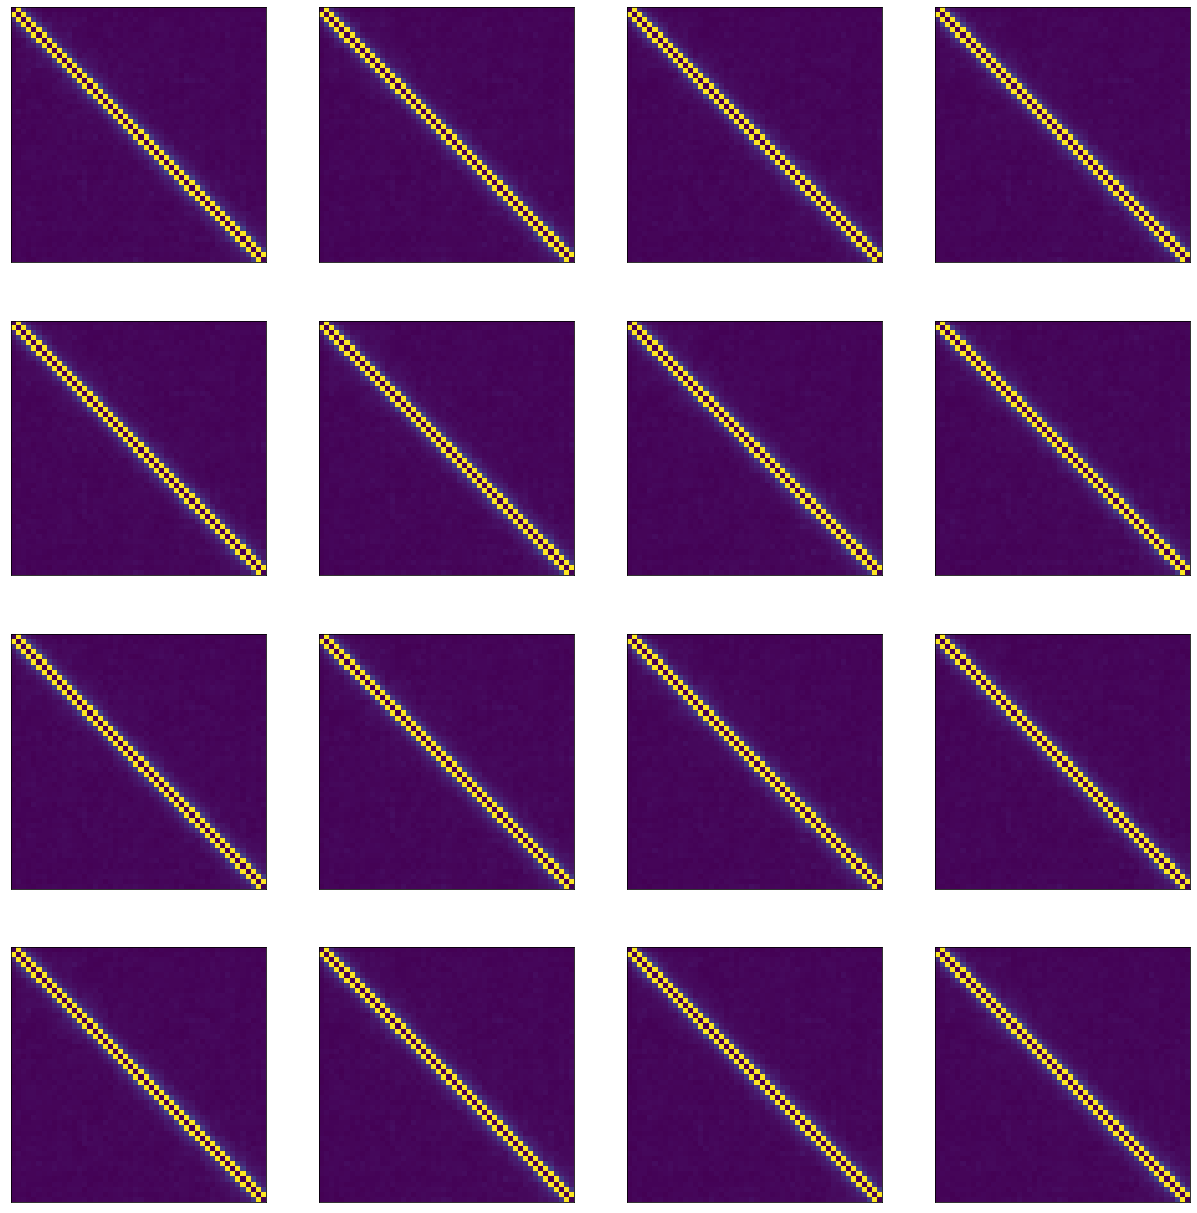

In [162]:
display_dictionary(save_name=save_folder+'UCLA_LMF_Dictionaries', W=W, figsize=[20,20])